This notebook contains the solution for my submission for kaggle contest: Multi-Class Prediction of Obesity Risk.

Objective: Use various factors to predict obesity risk in individuals, which is related to cardiovascular disease

Evaluation Metric: Accuracy

Data: The data contains 18 variables as follows:
  - id: patient id
  - Gender: gender of the patient (categorical- Male|Female)
  - Age: age of the patient (nominal)
  - Height: height of the patient (continuous)
  - Weight: weight of the patient (continuous)
  - family_history_with_overweight: if the patient has any family history in overweight (categorical:boolean - yes|no)
  - FAVC: Frequent consumption of high calorie food (categorical:boolean - yes|no)
  - FCVC: Frequency of consumption of vegetables (continuous)
  - NCP: Number of main meals (continuous)
  - CAEC: Consumption of food between meals (categorical- Sometimes|Frequently|Always|no)
  - SMOKE: whether the patient smokes (categorical:boolean - yes|no)
  - CH2O: Consumption of water daily (continuous)
  - SCC: Calories consumption monitoring (categorical:boolean - yes|no)
  - FAF: Physical activity frequency  (continuous)
  - TUE: Time using technology devices(continuous)
  - CALC: Consumption of alcohol (categorical- Sometimes|Frequently|Always|no)
  - MTRANS: Transportation mode used (categorical - Public_Transportation|Automobile|Walking|Motorbike|Bike)
  - NObeyesdad: Obesity Type (categorical - Obesity_Type_III|Obesity_Type_II|Normal_Weight|Obesity_Type_I|Insufficient_Weight|Overweight_Level_II|Overweight_Level_I)

Approach:

*   We will perform data wrangling on train dataset
*   Identify the features impacting the target variable.
*   Use machine learning model to predict




# Data Wrangling

#### Mounting drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/My Drive/

Mounted at /content/drive
/content/drive/My Drive


In [3]:
%cd /content/drive/My Drive/'Colab Notebooks'/Obesity_Classification

/content/drive/My Drive/Colab Notebooks/Obesity_Classification


#### load libraries

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score

In [2]:
# !unzip playground-series-s4e2.zip
# !pip install seaborn

In [2]:

from sklearn.preprocessing import LabelEncoder
from itertools import zip_longest

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Data Loading and Basic stats

In [3]:
df = pd.read_csv("train_O.csv")# load the dataset
df.head(3)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight


In [ ]:
df.shape # train dataset has 20758 records

(20758, 18)

The target column in 'NObeyesdad', the value counts for each category are shown below. We can see that Obesity_Type_III has highest records while Obesity_Type_I has lowest records and 50% less.

We can observe that the data is imbalanced. For now, we will proceed, and we will consider F1 score as well, to understand the performance.

F1 score is a better performance metric to analyze imbalanced dataset. It considers both precision and recall of the classifcation model across the classes

In [21]:
df['NObeyesdad'].value_counts()


Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: NObeyesdad, dtype: int64

there is no missing values present, skipping the missing value treatment

In [ ]:
df.isnull().sum()

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

listing out  all the data types of the features

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [4]:
df['bmi'] = df['Weight'] / (df['Height'] ** 2)

## Visualization

#### Nominal columns Visualization

In [5]:
nonobj_columns =  df.drop(columns=['id']).select_dtypes(include=['int64','float64']).columns
nonobj_columns

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'bmi'], dtype='object')

In [89]:
df.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,bmi
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756,30.241842
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113,8.333932
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000,12.868541
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000,24.088223
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887,29.384757
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000,37.011168
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000,54.997991


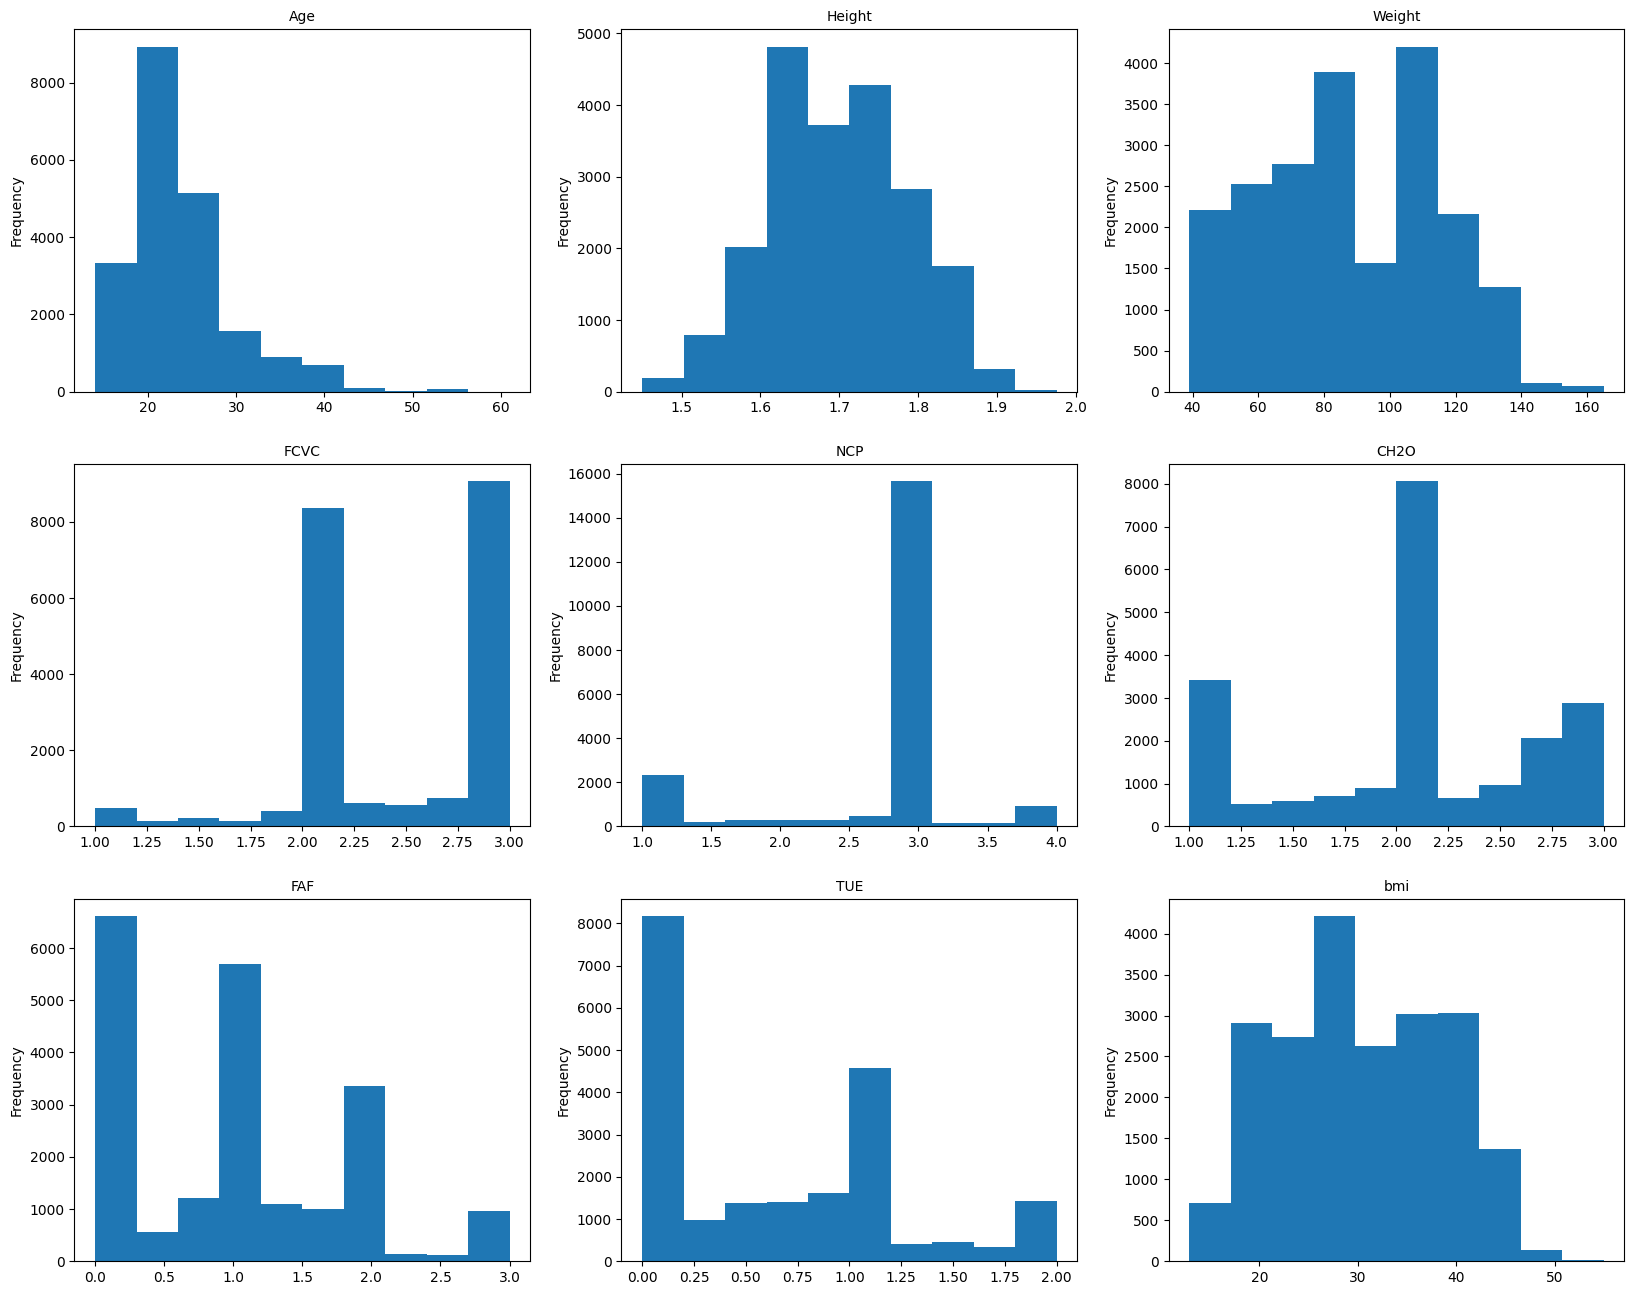

In [101]:
fig, axes = plt.subplots(figsize=(20, 16),nrows=3,ncols=3)
for col, ax in zip_longest(nonobj_columns, axes.flat):
  if col!='id':
    if col:
        df[col].plot(kind='hist', ax=ax, title=col)
        ax.set_title(col, fontsize=10)
    else:
        fig.delaxes(ax)

basic stats: from the below table, we can observe the following:
- Age: The mean age is 23 and 75th percentile is 26, while maximum is 61, this shows right skew
- Height: The average height is 1.7 while min and max are 1.45 and 1.9, seems like mostly normally distributed
- Weight: The average weight is 87 pounds, while minimum is 39 and max in 165, looks like right skewed distribution
- FCVC: slightly left skewed
- NCP: normal distributed
- CH20: normal distributed
- FAF: 0 value has high frequency
- TUE: 0 value has high frequency

#### Object columns Visualization

In [6]:
object_columns =  df.select_dtypes(include='object').columns
# df.drop(columns='NObeyesdad').select_dtypes(include='object').columns

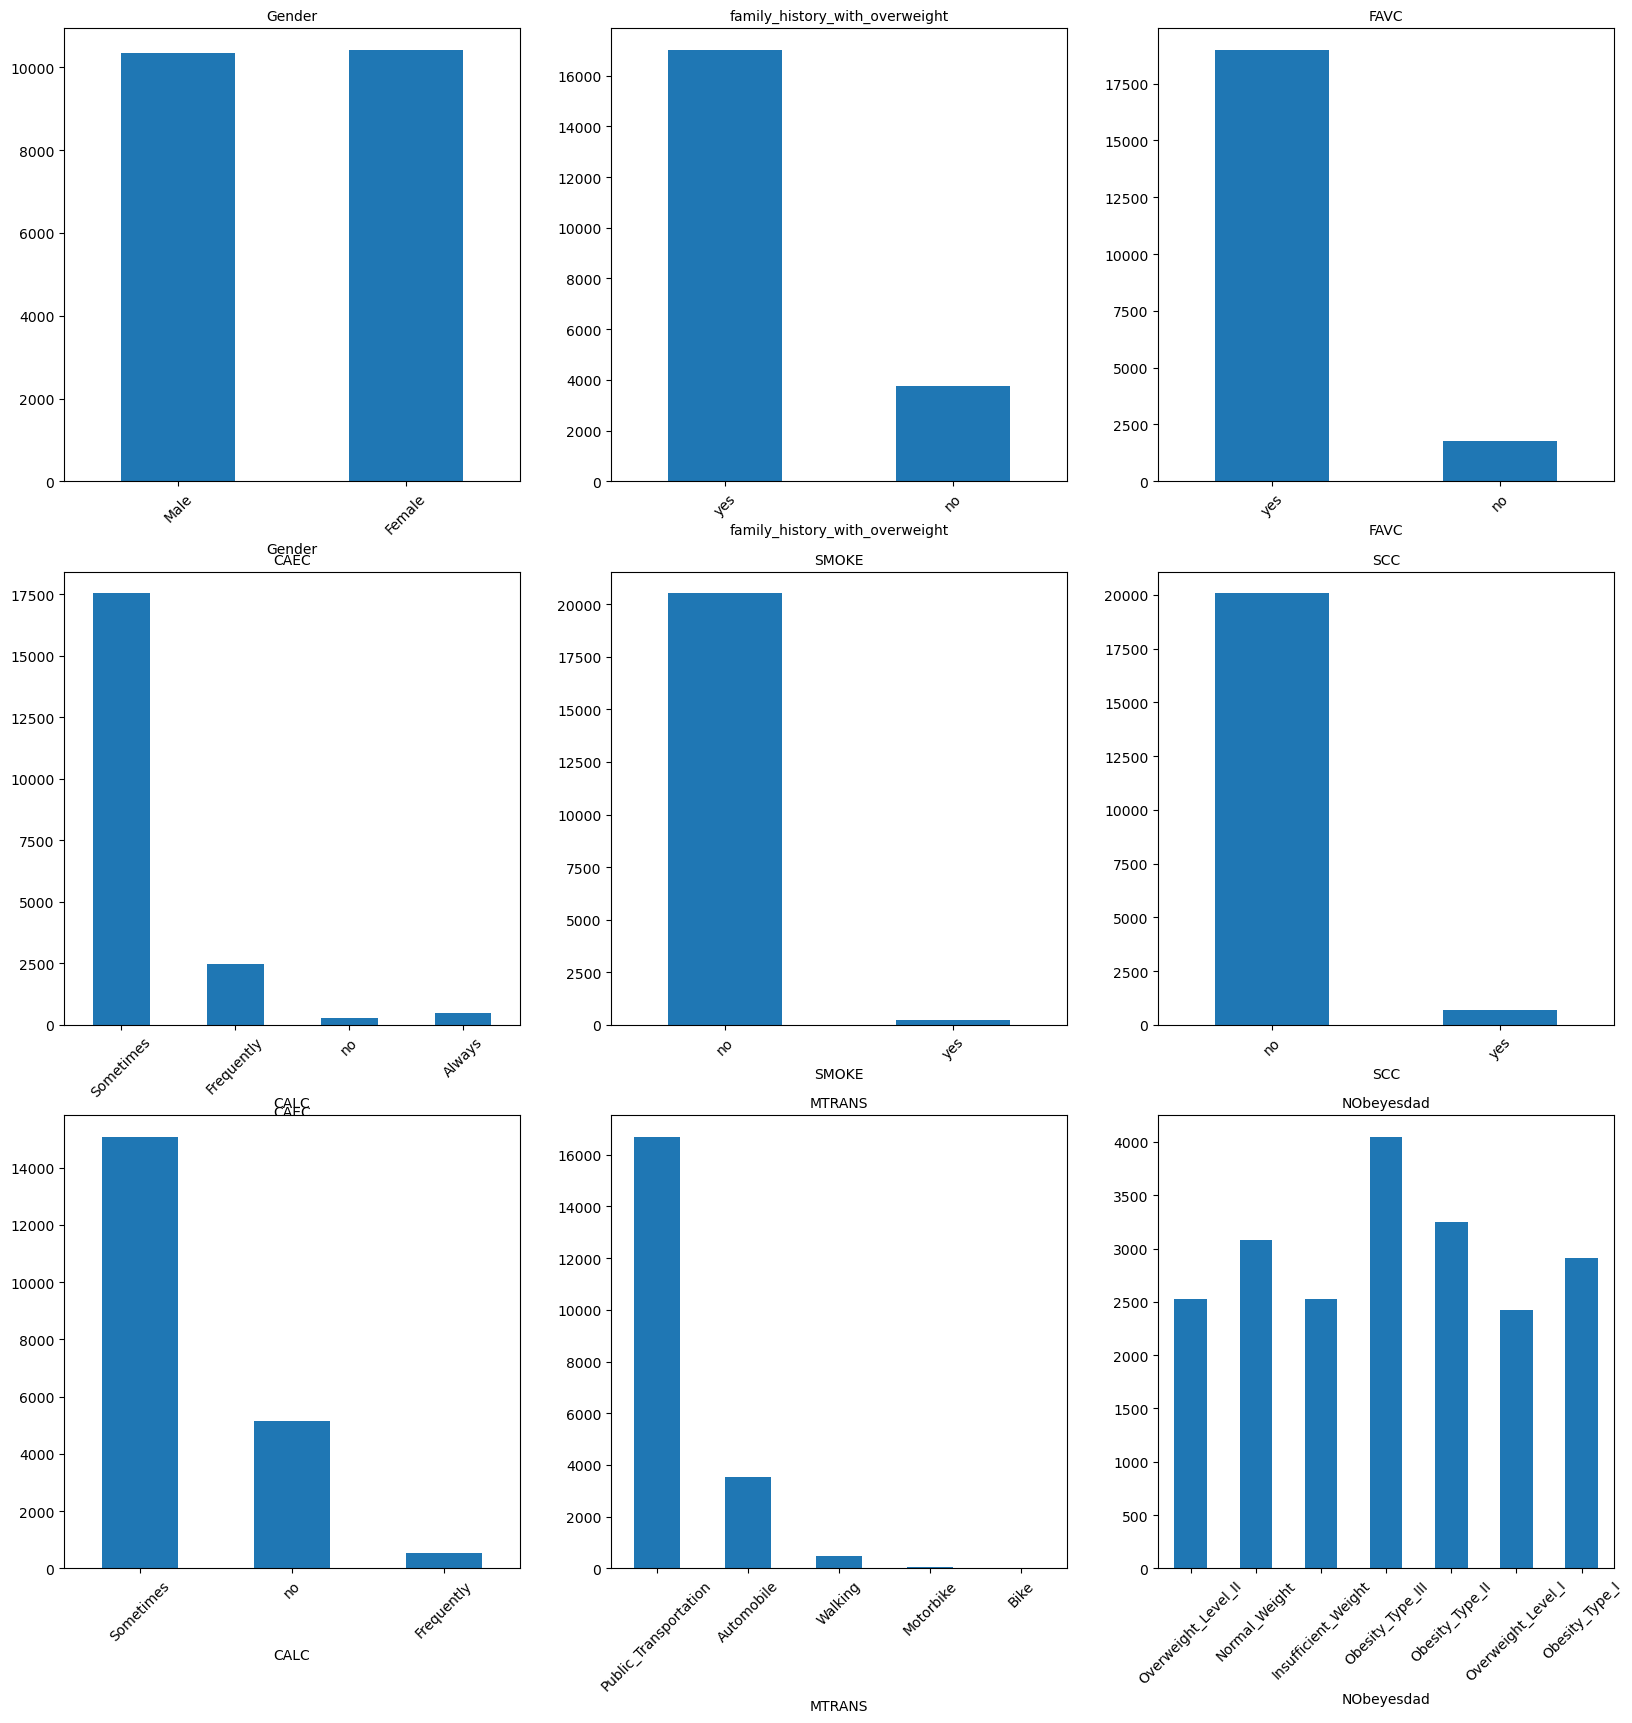

In [199]:
fig, axes = plt.subplots(figsize=(20, 20),nrows=3,ncols=3)
for col, ax in zip_longest(object_columns, axes.flat):
    if col:
        df[col].value_counts(sort=False).plot(kind='bar', ax=ax, rot=45, title=col)
        ax.set_title(col, fontsize=10)
    else:
        fig.delaxes(ax)


The column Gender has the category balanced throughout the dataset
The remaining columns like family_history_with_overweight, FAVC, CAEC, SMOKE, SCC, CALC, MTRANS have one class on majority while the other classes are not

# Data Preprocessing

In [338]:
df_mod = df.copy()

In [339]:
# one hot encoding for all the object dependent columns
label_encoders={}
for column in df_mod.select_dtypes(include='object').columns:
  label_encoder = LabelEncoder()
  if len(df_mod[column].unique())<3:
    df_mod[column] = label_encoder.fit_transform(df_mod[column])
    label_encoders[column] = label_encoder
  elif column== 'NObeyesdad':
    df_mod[column] = label_encoder.fit_transform(df_mod[column])
    label_encoders[column] = label_encoder
  else:
    df_mod= pd.get_dummies(df_mod, columns=[column], prefix=column, drop_first=False, dtype=float)

df_mod.head(3)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,...,CAEC_Sometimes,CAEC_no,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0,1,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,2,0,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## SMOTE

Since we already have observed that target variable is imbalanced I will be doing oversampling to balance the dataset.
We tried using undersampling, oversampling, ADASYN and SMOTE, and SMOTE had a better performance. 
SMOTE creates synthetic samples for the minority class by interpolating between existing minority class samples. 


In [9]:
# !pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from collections import Counter

In [335]:
oversample = SMOTE()
X, y = oversample.fit_resample(df_mod.drop(columns=['id','NObeyesdad',"Weight","Height"]), df_mod['NObeyesdad'])
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({6: 4046, 1: 4046, 0: 4046, 4: 4046, 3: 4046, 5: 4046, 2: 4046})


In [341]:
df_mod.shape
# (20758, 28)

(20758, 28)

the dependent variables are oversampled such that all the classes for the target column NObeyesdad has the same number of records as the largest category 

In [354]:
from scipy.stats  import ks_2samp, anderson_ksamp

# Assuming you have your original data (X_orig) and resampled data (X_resampled)

# Specify features to compare (adjust as needed)
features_to_compare = list(df_mod.drop(columns=['id','NObeyesdad',"Weight","Height"]))  # Replace with your feature names
All_Stats_sampling={}
# Loop through features and perform tests
for feature in features_to_compare:
  Stats_sampling={}

  # print("feature",feature)
  # Kolmogorov-Smirnov Test
  statistic, pvalue = ks_2samp(df_mod[feature], X[feature])
  Stats_sampling={"Statistic": and_val.statistic,"p-value": and_val.pvalue}
  All_Stats_sampling[feature+'__Kolmogorov-Smirnov Test']=Stats_sampling
  # Anderson-Darling Test
  and_val= anderson_ksamp([df_mod[feature], X[feature]])
  # print(f"Anderson-Darling Test (feature: {feature}):")
  # print(f"- Statistic: {and_val.statistic}")
  # print(f"- p-value: {and_val.pvalue}")
  # print("\n")  # Add newline for readability
  # Stats_sampling[feature]='Anderson-Darling Test'
  Stats_sampling={"Statistic": and_val.statistic,"p-value": and_val.pvalue}
  All_Stats_sampling[feature+'__Anderson-Darling Test']=Stats_sampling

  and_val= ranksums(df_mod[feature], X[feature])
  Stats_sampling={"Statistic": and_val.statistic,"p-value": and_val.pvalue}
  All_Stats_sampling[feature+'__Mann-Whitney U Test']=Stats_sampling
# k = pd.DataFrame(All_Stats_sampling).T.reset_index()
  # break
k = pd.DataFrame(All_Stats_sampling).T.reset_index()

/var/folders/2r/ctcx_s5d1kvdlr_h8kjq6w340000gn/T/ipykernel_35292/2205668714.py:18: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  and_val= anderson_ksamp([df_mod[feature], X[feature]])
/var/folders/2r/ctcx_s5d1kvdlr_h8kjq6w340000gn/T/ipykernel_35292/2205668714.py:18: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  and_val= anderson_ksamp([df_mod[feature], X[feature]])


In [358]:
pd.set_option('display.max_rows', None)
k['Feature']=k['index'].str.split('__').str[0]
k['Test']=k['index'].str.split('__').str[-1]
k['pass']=np.where(k['p-value']>0.05,1,0)
k.sort_values("Feature").drop(columns="index")

,Statistic,p-value,Feature,Test,pass
3,-1.209255,2.265650e-01,Age,Kolmogorov-Smirnov Test,1
4,27.182467,1.000000e-03,Age,Anderson-Darling Test,0
5,5.600252,2.140407e-08,Age,Mann-Whitney U Test,0
38,-0.208872,8.345485e-01,CAEC_Always,Mann-Whitney U Test,1
37,-0.000603,2.500000e-01,CAEC_Always,Anderson-Darling Test,1
36,13.670025,1.533422e-42,CAEC_Always,Kolmogorov-Smirnov Test,0
41,-3.034900,2.406153e-03,CAEC_Frequently,Mann-Whitney U Test,0
40,36.531054,1.000000e-03,CAEC_Frequently,Anderson-Darling Test,0
39,-0.208872,8.345485e-01,CAEC_Frequently,Kolmogorov-Smirnov Test,1
44,3.256381,1.128424e-03,CAEC_Sometimes,Mann-Whitney U Test,0


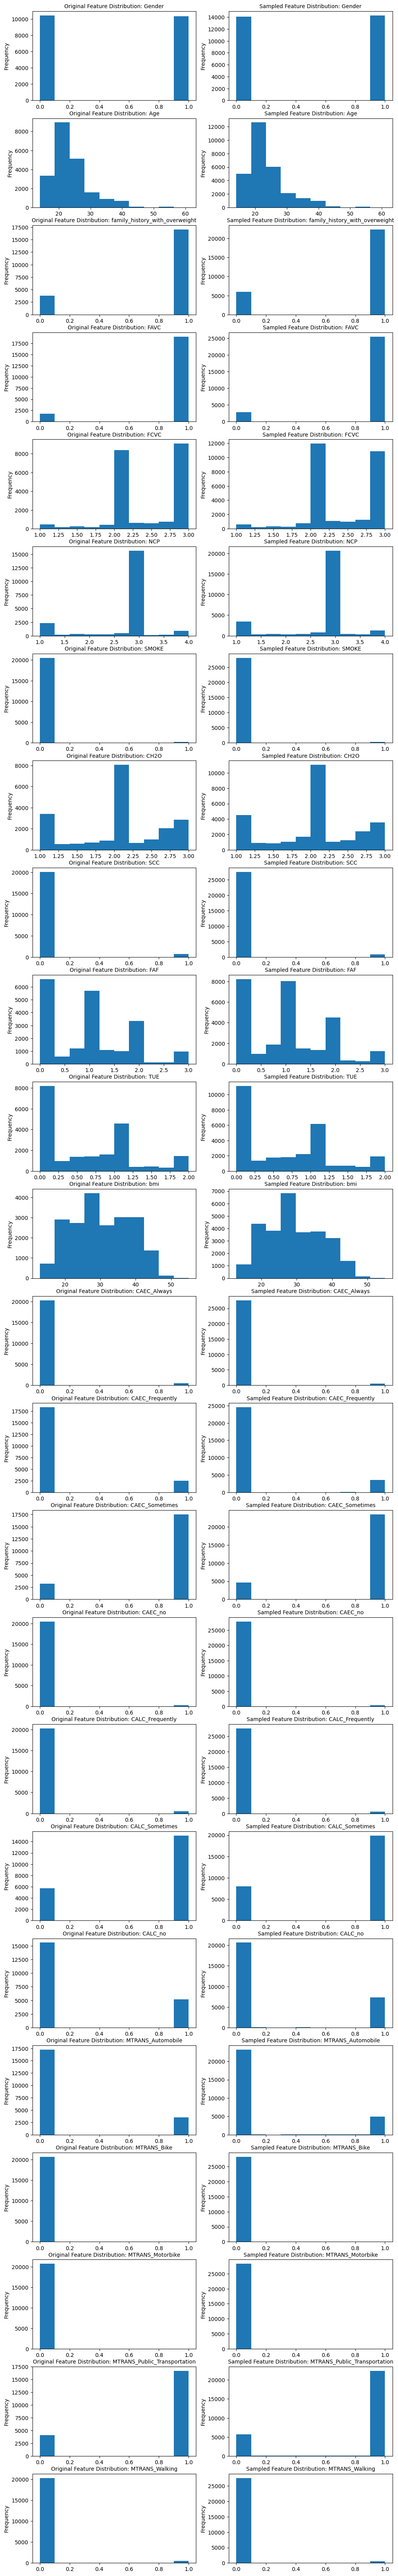

In [323]:
fig, axes = plt.subplots(figsize=(12, 100),nrows=28,ncols=2)
count=0
for col, ax in zip_longest(df_mod.drop(columns=['id','NObeyesdad',"Weight","Height"]).columns.repeat(2), axes.flat):
  if count==0:
    if col:
        df_mod[col].plot(kind='hist', ax=ax, title=col)
        ax.set_title("Original Feature Distribution: "+col, fontsize=10)
        count+=1
    else:
        fig.delaxes(ax)
  else:
    if col:
        X[col].plot(kind='hist', ax=ax, title=col)
        ax.set_title("Sampled Feature Distribution: "+col, fontsize=10)
        count=0
    else:
        fig.delaxes(ax)  

Computed Kolmogorov-Smirnov Test,Mann-Whitney U Test and Anderson-Darling Test to check the differences between the original dataset and oversample dataset ECDF. We can observe certain features to have very less p-value, reject the null-hypothesis
that the difference between ECDF is statistically significant. 
However, the distributions of these features, visually seem absolutely fine! This may be cause, certain columns being on-hot encoded. Hence, we will proceed with this data

#### Normalzing data
Since we have different scales of data we will be using RobustScaler to transform.
We are using Robust Scaler to normalize, this is because the data is not normally distributed.

In [101]:
from sklearn.preprocessing import RobustScaler

In [360]:
scaler = RobustScaler()
df_standardized = scaler.fit_transform(X)

In [361]:
df_select = pd.DataFrame(df_standardized,columns=df_mod.drop(columns=['id','NObeyesdad',"Weight","Height"]).columns)
df_select.head(3)

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,SCC,FAF,...,CAEC_Sometimes,CAEC_no,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0.0,0.372076,0.0,0.0,-0.204914,-2.109764,0.0,1.157420,0.0,-0.656546,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,-0.630615,0.0,0.0,-0.204914,0.000000,0.0,0.000000,0.0,0.000000,...,-1.0,0.0,0.0,-1.0,1.0,1.0,0.0,0.0,-1.0,0.0
2,-1.0,-0.630615,0.0,0.0,-0.324380,-200.620816,0.0,-0.135849,0.0,-0.087948,...,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0


#### Data Split

Splitting the dataset with 80%-20% ration for train and validation 

In [362]:
from sklearn.model_selection import train_test_split

raw_X_train, raw_X_test, y_train, y_test  = train_test_split(df_select, y, test_size=0.2, random_state=42,stratify=y)
raw_X_train.shape,y_train.shape

((22657, 24), (22657,))

/Users/ananyadas/anaconda3/envs/nn_llm/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


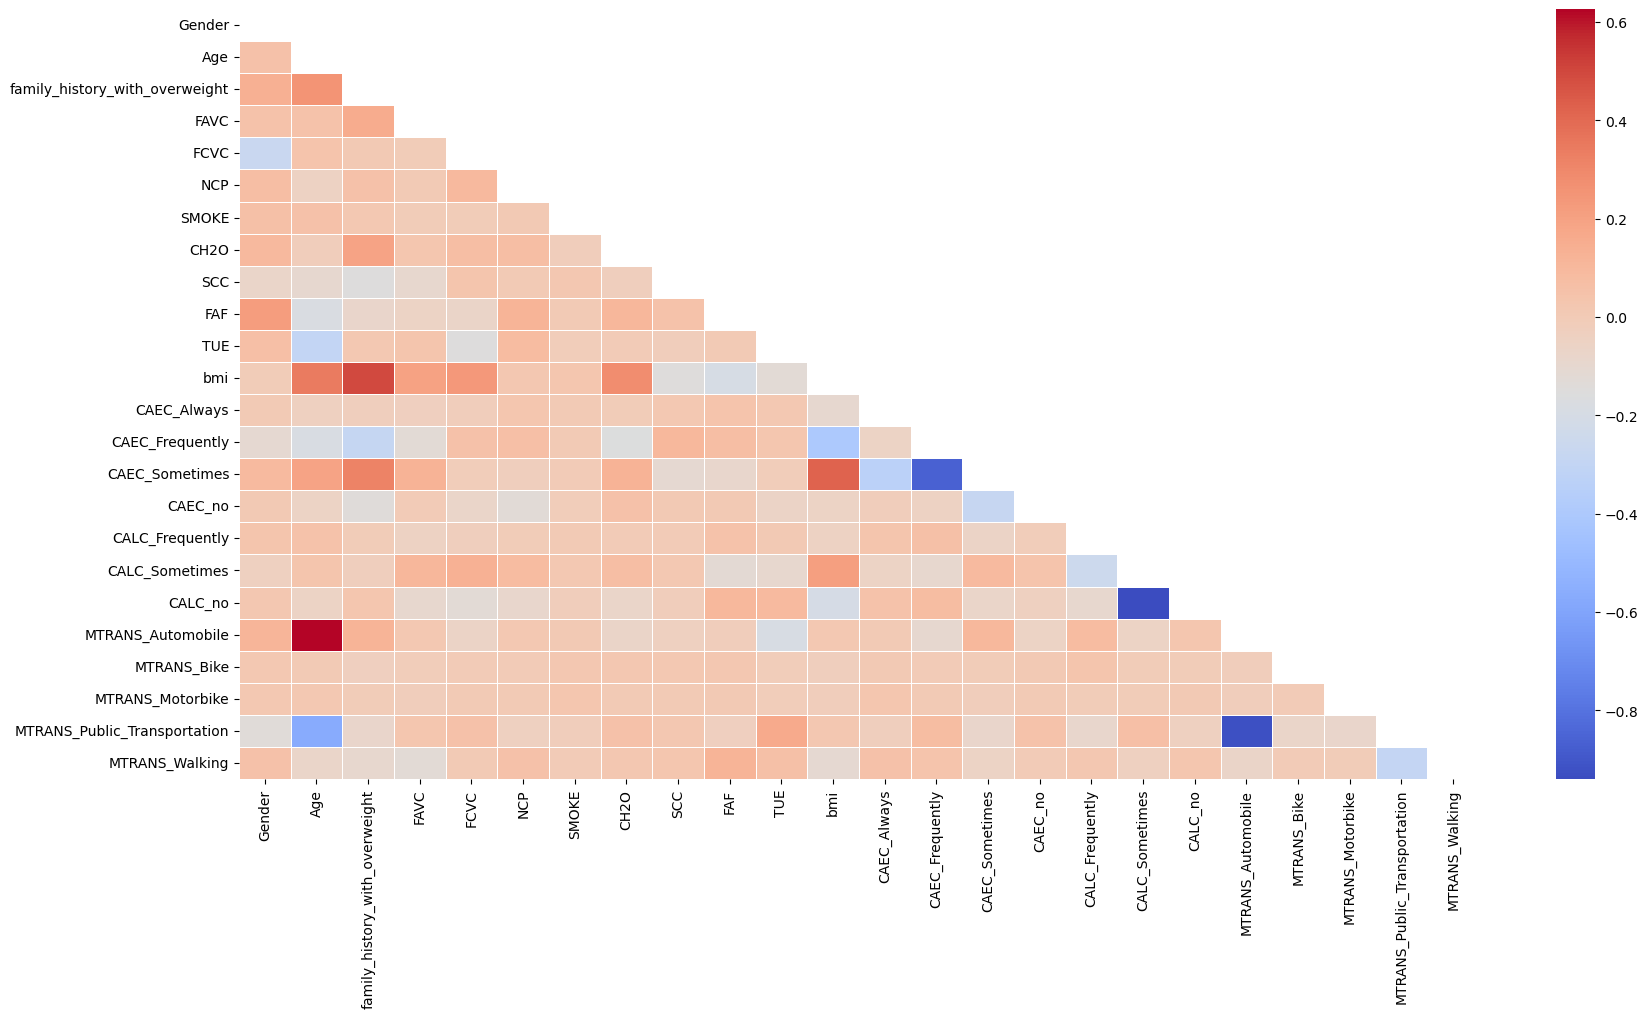

In [139]:
corr_matrix=raw_X_train.corr()
fig = plt.subplots(figsize=(20, 10))
sns.heatmap(corr_matrix,mask=np.triu(np.ones_like(corr_matrix, dtype=bool)),annot=True, fmt=".2f", linewidths=0.5,cmap='coolwarm')
plt.show()

we can observe that features "MTRANS_Automobile","CALC_no","CAEC_Sometimes" are highly correlated, hence we will remove them

In [148]:
raw_X_train=raw_X_train.drop(columns=["MTRANS_Automobile","CALC_no","CAEC_Sometimes"])
raw_X_test=raw_X_test.drop(columns=["MTRANS_Automobile","CALC_no","CAEC_Sometimes"])

In [201]:
raw_X_train=raw_X_train[['Gender', 'Age','bmi','FCVC']]
raw_X_test=raw_X_test[['Gender', 'Age','bmi','FCVC']]

# Feature Importance

Using the Random forest classifier, to identify the important features

In [204]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

rfc = RandomForestClassifier(n_estimators=100, random_state=42)  # Set hyperparameters as needed
rfc.fit(X, y)

# Select features based on importance scores
model = SelectFromModel(rfc, prefit=True, threshold=0.05)  # Select features with importance > 0.05
X_selected = model.transform(X)

# Display the most important features
feature_names = X.columns.tolist()
importances = rfc.feature_importances_
sorted_idx = importances.argsort()[::-1]  # Sort features by decreasing importance
# top_features =[] feature_names[sorted_idx]  # Select top 10 features (adjust as needed)
top_features =[ feature_names[x] for x in sorted_idx[0:10]]

/Users/ananyadas/anaconda3/envs/nn_llm/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


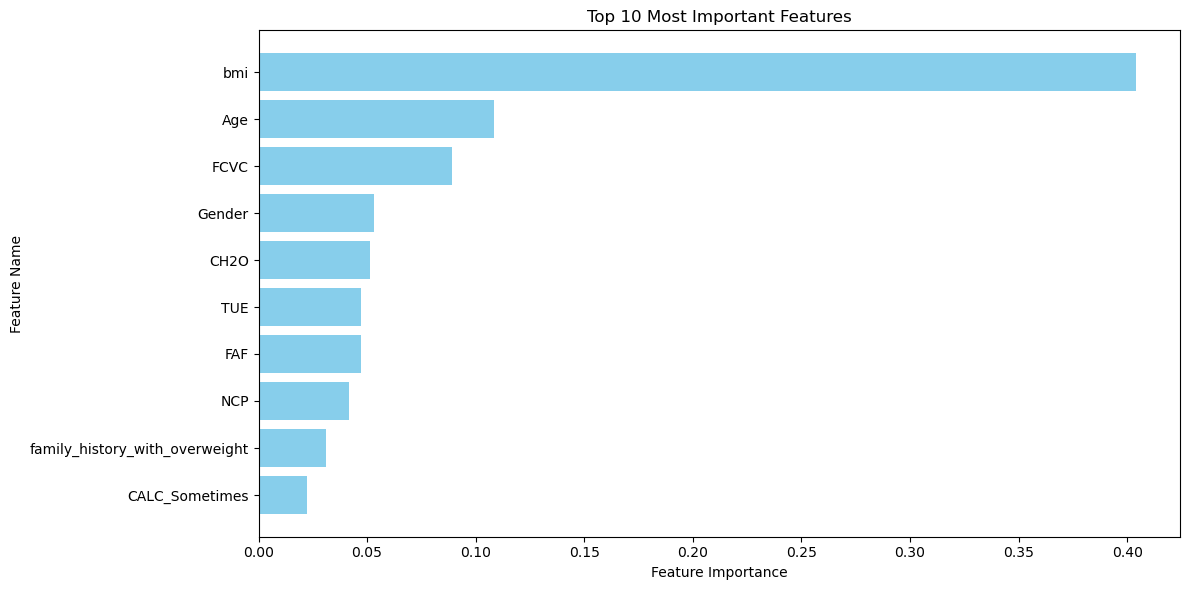

In [205]:
plt.figure(figsize=(12, 6))
plt.barh(top_features, importances[sorted_idx[:10]], color='skyblue')  # Adjust colors as desired
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top 10 Most Important Features")
plt.gca().invert_yaxis()  # Invert y-axis to display top features at the top
plt.tight_layout()
plt.show()

# Data Modelling

Showcasing all the best models with their best performance for the multi-class classfier

In [16]:
accuracies=[] # to save all models accuracies
from sklearn.metrics import roc_auc_score

f1s=[]# to save all models F1
aucs=[] # to save all models AUC
model_performances={}# to save all models performance metrics


#### Logistic regression

In [17]:
#logistic regression classifier
sgd_model = SGDClassifier(loss='log_loss', random_state=0, max_iter=100)
sgd_model.fit(raw_X_train, y_train)
# Make predictions on the test set
y_pred_lg_train = sgd_model.predict(raw_X_train)
y_pred_lg= sgd_model.predict(raw_X_test)
# Evaluate the model
accuracy_lg_train = accuracy_score(y_train, y_pred_lg_train)
accuracy_lg_test = accuracy_score(y_pred_lg, y_test)
print(f"Train Set Accuracy: {accuracy_lg_train}")
print(f"Test Set Accuracy: {accuracy_lg_test}")
f1_score_lg_train = f1_score(y_train, y_pred_lg_train, average='macro')
f1_score_lg_test = f1_score(y_test, y_pred_lg, average='macro')
print(f"Train Set f1_score: {f1_score_lg_train}")
print(f"Test Set f1_score: {f1_score_lg_test}")


Train Set Accuracy: 0.6092156949287196
Test Set Accuracy: 0.5924095322153574
Train Set f1_score: 0.604694341451167
Test Set f1_score: 0.593507312453883


/Users/ananyadas/anaconda3/envs/nn_llm/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [18]:
perf={}
auc = roc_auc_score(y_test, sgd_model.predict_proba(raw_X_test), multi_class="ovr")
perf['train_acc']=accuracy_lg_train
perf['test_acc']=accuracy_lg_test
perf['train_f1']=f1_score_lg_train
perf['test_f1']=f1_score_lg_test
perf['auc']=auc
model_performances['Logistic Regression']=perf

#### SVM classifier

In [19]:
from sklearn.svm import SVC
# Initialize the SVM classifier
svm_classifier = SVC(kernel='linear', C=1.,probability=True)

# Train the SVM classifier on the training data
svm_classifier.fit(raw_X_train, y_train)

# Make predictions on the test set
y_pred_svm_train = svm_classifier.predict(raw_X_train)
y_pred_svm= svm_classifier.predict(raw_X_test)
# Evaluate the model
accuracy_svm_train = accuracy_score(y_train, y_pred_svm_train)
accuracy_svm_test = accuracy_score(y_pred_svm, y_test)
print(f"Train Set Accuracy: {accuracy_svm_train}")
print(f"Test Set Accuracy: {accuracy_svm_test}")
f1_score_svm_train = f1_score(y_train, y_pred_svm_train, average='macro')
f1_score_svm_test = f1_score(y_test, y_pred_svm, average='macro')
print(f"Train Set f1_score: {f1_score_svm_train}")
print(f"Test Set f1_score: {f1_score_svm_test}")

Train Set Accuracy: 0.8543055126450987
Test Set Accuracy: 0.848720211827008
Train Set f1_score: 0.8531238557210798
Test Set f1_score: 0.8493081136627028


In [20]:
perf={}
auc = roc_auc_score(y_test, svm_classifier.predict_proba(raw_X_test), multi_class="ovr")
perf['train_acc']=accuracy_svm_train
perf['test_acc']=accuracy_svm_test
perf['train_f1']=f1_score_svm_train
perf['test_f1']=f1_score_svm_test
perf['auc']=auc
model_performances['SVM Classifier']=perf

#### RandomForest with one versus rest classifier

In [21]:
from sklearn.multiclass import OneVsRestClassifier as ovr
new_mod = ovr(RandomForestClassifier(random_state=42,n_estimators=300,max_features='log2',class_weight = "balanced",criterion='entropy',max_depth=17), n_jobs=None, verbose=0)
new_mod.fit(raw_X_train, y_train)
# Make predictions on the test set
y_pred_rf_train = new_mod.predict(raw_X_train)
y_pred_rf = new_mod.predict(raw_X_test)

# Evaluate the model
accuracy_rf_train = accuracy_score(y_train, y_pred_rf_train)
accuracy_rf_test = accuracy_score(y_test, y_pred_rf)
print(f"Train Set Accuracy: {accuracy_rf_train}")
print(f"Test Set Accuracy: {accuracy_rf_test}")
f1_score_rf_train = f1_score(y_train, y_pred_rf_train, average='macro')
f1_score_rf_test = f1_score(y_test, y_pred_rf, average='macro')
print(f"Train Set f1_score: {f1_score_rf_train}")
print(f"Test Set f1_score: {f1_score_rf_test}")

Train Set Accuracy: 0.9866266496005649
Test Set Accuracy: 0.8954986760812004
Train Set f1_score: 0.9865989152234641
Test Set f1_score: 0.89644093942372


In [22]:
perf={}
auc = roc_auc_score(y_test, new_mod.predict_proba(raw_X_test), multi_class="ovr")
perf['train_acc']=accuracy_rf_train
perf['test_acc']=accuracy_rf_test
perf['train_f1']=f1_score_rf_train
perf['test_f1']=f1_score_rf_test
perf['auc']=auc
model_performances['Random Forest']=perf

#### Lightgbm with oneversus rest classifier

In [23]:
best_params = {         # Objective function for the model
               'objective': 'multiclass',
  "metric": "multi_logloss",          # Evaluation metric
  "verbosity": -1,                    # Verbosity level (-1 for silent)
  "boosting_type": "gbdt",            # Gradient boosting type
  "random_state": 42,       # Random state for reproducibility
  'learning_rate': 0.046,
  'n_estimators': 287,
  'lambda_l1': 0.0072,
  'lambda_l2': 0.023,
  'max_depth': 8,
  'colsample_bytree': 0.373,
  'subsample': 0.866,
  'min_child_samples': 33}

obtained above parameters after gridsearch

In [25]:
from sklearn.multiclass import OneVsOneClassifier as ovr
from lightgbm import LGBMClassifier

lgbm_new_mod = LGBMClassifier(**best_params, n_jobs=4)
lgbm_new_mod.fit(raw_X_train, y_train)
# Make predictions on the test set
y_pred_lgbm_train = lgbm_new_mod.predict(raw_X_train)
y_pred_lgbm = lgbm_new_mod.predict(raw_X_test)

# Evaluate the model
accuracy_lgbm_train = accuracy_score(y_train, y_pred_lgbm_train)
accuracy_lgbm_test = accuracy_score(y_test, y_pred_lgbm)
print(f"Train Set Accuracy: {accuracy_lgbm_train}")
print(f"Test Set Accuracy: {accuracy_lgbm_test}")
f1_score_lgbm_train = f1_score(y_train, y_pred_lgbm_train, average='macro')
f1_score_lgbm_test = f1_score(y_test, y_pred_lgbm, average='macro')
print(f"Train Set f1_score: {f1_score_lgbm_train}")
print(f"Test Set f1_score: {f1_score_lgbm_test}")

# test_df_standardized =scaler.transform(test_df[raw_X_train.columns])
# y_pred_rf = new_mod.predict(test_df_standardized)
# test_df['NObeyesdad']=label_encoders['NObeyesdad'].inverse_transform(y_pred_rf)
# test_df[['id','NObeyesdad']].to_csv('Submission_Check9.csv',index=False)

Train Set Accuracy: 0.954274617116123
Test Set Accuracy: 0.8914386584289496
Train Set f1_score: 0.9541116031351181
Test Set f1_score: 0.8923259334496743


In [26]:
perf={}
auc = roc_auc_score(y_test, lgbm_new_mod.predict_proba(raw_X_test), multi_class="ovr")
perf['train_acc']=accuracy_lgbm_train
perf['test_acc']=accuracy_lgbm_test
perf['train_f1']=f1_score_lgbm_train
perf['test_f1']=f1_score_lgbm_test
perf['auc']=auc
model_performances['Light GBM']=perf

In [27]:
# !pip install xgboost
from xgboost import XGBClassifier
xgb_classifier = XGBClassifier(random_state=42,learning_rate=0.05,objective='multi:softmax',criterion='mlog_loss',reg_lambda= 5)
xgb_classifier.fit(raw_X_train, y_train)
# Make predictions on the test set
y_pred_xgb_train = xgb_classifier.predict(raw_X_train)
y_pred_xgb = xgb_classifier.predict(raw_X_test)

# Evaluate the model
accuracy_xgb_train = accuracy_score(y_train, y_pred_xgb_train)
accuracy_xgb_test = accuracy_score(y_test, y_pred_xgb)
print(f"Train Set Accuracy: {accuracy_xgb_train}")
print(f"Test Set Accuracy: {accuracy_xgb_test}")
f1_score_xgb_train = f1_score(y_train, y_pred_xgb_train, average='macro')
f1_score_xgb_test = f1_score(y_test, y_pred_xgb, average='macro')
print(f"Train Set f1_score: {f1_score_xgb_train}")
print(f"Test Set f1_score: {f1_score_xgb_test}")

[16:47:56] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "criterion" } are not used.

Train Set Accuracy: 0.9025466743169881
Test Set Accuracy: 0.8774933804060018
Train Set f1_score: 0.9020551126700213
Test Set f1_score: 0.8781958653880803


In [28]:
perf={}
auc = roc_auc_score(y_test, xgb_classifier.predict_proba(raw_X_test), multi_class="ovr")
perf['train_acc']=accuracy_xgb_train
perf['test_acc']=accuracy_xgb_test
perf['train_f1']=f1_score_xgb_train
perf['test_f1']=f1_score_xgb_test
perf['auc']=auc
model_performances['XGB Classifier']=perf

In [29]:
# !pip install catboost
from catboost import CatBoostClassifier

In [30]:
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(raw_X_train, y_train)
y_pred_cat_train = cat_model.predict(raw_X_train)
y_pred_cat = cat_model.predict(raw_X_test)

# Evaluate the model
accuracy_cat_train = accuracy_score(y_train, y_pred_cat_train)
accuracy_cat_test = accuracy_score(y_test, y_pred_cat)
print(f"Train Set Accuracy: {accuracy_cat_train}")
print(f"Test Set Accuracy: {accuracy_cat_test}")
f1_score_cat_train = f1_score(y_train, y_pred_cat_train, average='macro')
f1_score_cat_test = f1_score(y_test, y_pred_cat, average='macro')
print(f"Train Set f1_score: {f1_score_cat_train}")
print(f"Test Set f1_score: {f1_score_cat_test}")

Train Set Accuracy: 0.9483161936708302
Test Set Accuracy: 0.8924977934686672
Train Set f1_score: 0.9480836664301722
Test Set f1_score: 0.8931529499193263


In [31]:
perf={}
auc = roc_auc_score(y_test, cat_model.predict_proba(raw_X_test), multi_class="ovr")
perf['train_acc']=accuracy_cat_train
perf['test_acc']=accuracy_cat_test
perf['train_f1']=f1_score_cat_train
perf['test_f1']=f1_score_cat_test
perf['auc']=auc
model_performances['CatBoost']=perf

In [368]:
k = pd.DataFrame(model_performances).T.reset_index()

## Visualization of Performance Metrics

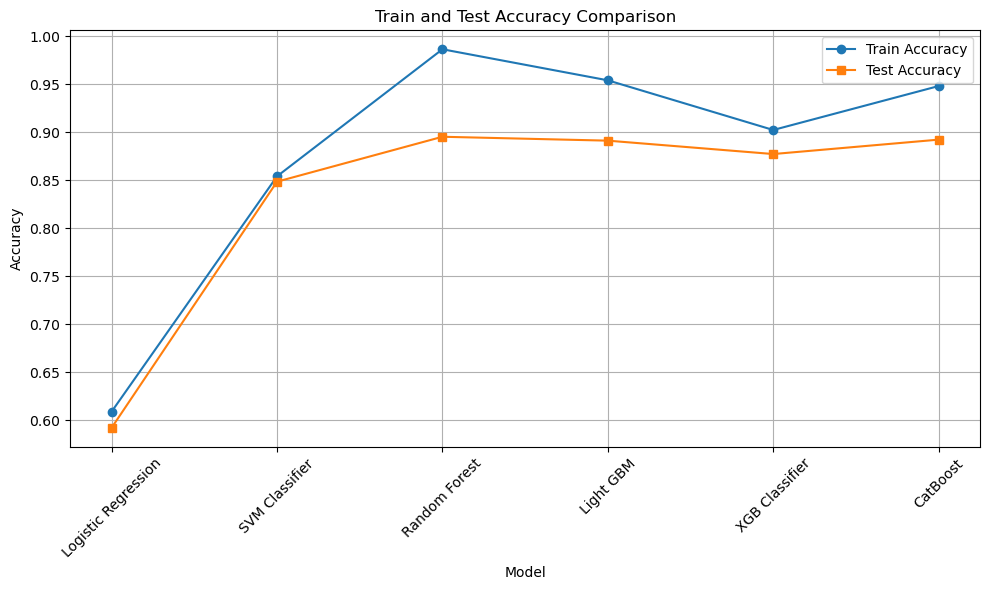

In [66]:

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(k["index"],k["train_acc"], marker='o', label='Train Accuracy')
plt.plot(k["index"],k["test_acc"], marker='s', label='Test Accuracy')

# Set labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy Comparison')

# Add legend and grid
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

From the above, we can see that LightGBM, XGB and Catboost have better results. The XGB classifier has minimum difference between the train and test accuracy. The LightGBM, and Catboost seems to be slightly overfitting

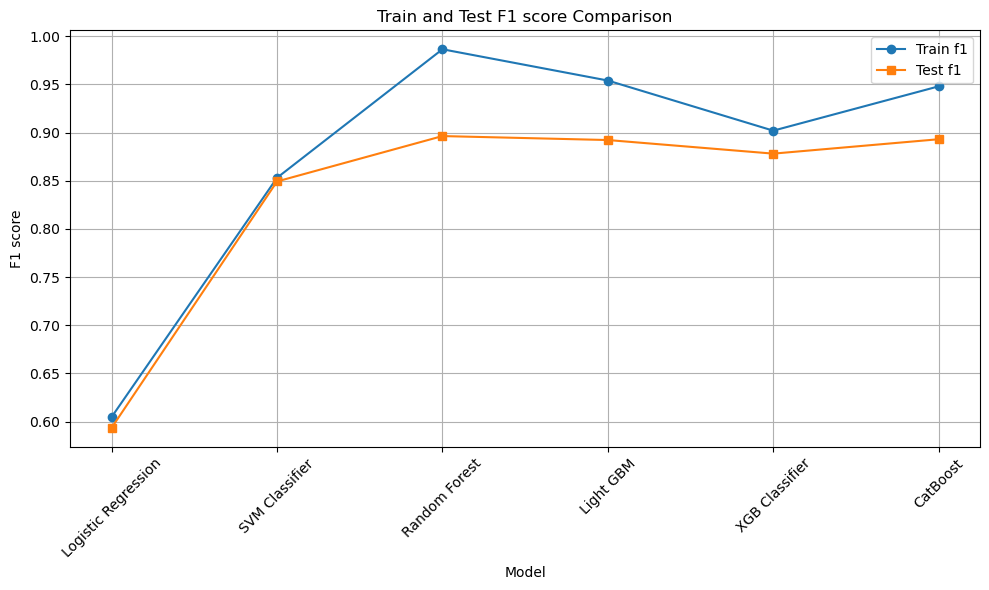

In [366]:
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(k["index"],k["train_f1"], marker='o', label='Train f1')
plt.plot(k["index"],k["test_f1"], marker='s', label='Test f1')

# Set labels and title
plt.xlabel('Model')
plt.ylabel('F1 score')
plt.title('Train and Test F1 score Comparison')

# Add legend and grid
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

Similar to accuracy, we can see that LightGBM, XGB and Catboost have better results. The XGB classifier has minimum difference between the train and test F1 score. The LightGBM, and Catboost seems to be slightly overfitting

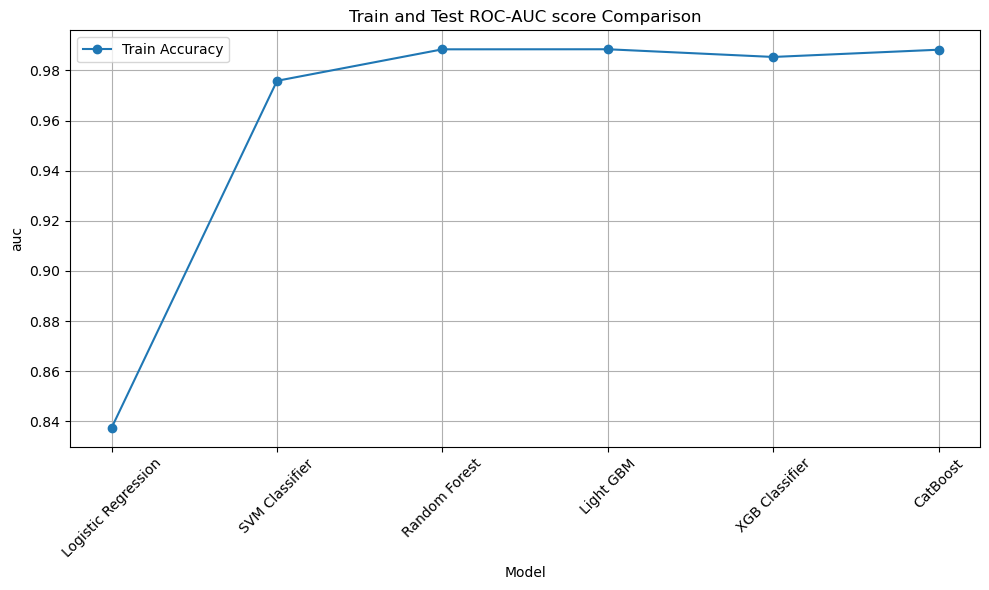

In [367]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(k["index"],k["auc"], marker='o', label='Train Accuracy')
# plt.plot(k["index"],k["test_f1"], marker='s', label='Test Accuracy')

# Set labels and title
plt.xlabel('Model')
plt.ylabel('auc')
plt.title('Train and Test ROC-AUC score Comparison')

# Add legend and grid
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

AUC value seems to be absolutely fine!

# Cross Validation

In [363]:
from sklearn.model_selection import StratifiedKFold

# Assuming you have already defined best_params and loaded raw_X_train and y_train

# Set up Stratified K-Fold cross-validation
n_splits = 4  # Adjust number of folds as needed
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = []
for train_index, val_index in skf.split(raw_X_train, y_train):
  X_train, X_val = raw_X_train.iloc[train_index], raw_X_train.iloc[val_index]
  temp_y_train, temp_y_val = y_train.iloc[train_index], y_train.iloc[val_index]

  # Create and fit the model on the training fold
  new_mod = LGBMClassifier(**best_params, n_jobs=4)
  new_mod.fit(X_train, temp_y_train)

  # Evaluate the model on the validation fold (e.g., using accuracy)
  # Replace this with your desired evaluation metric
  val_score = new_mod.score(X_val, temp_y_val)
  cv_scores.append(val_score)

# Print or analyze the cross-validation scores
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {np.mean(cv_scores)}")

Cross-Validation Scores: [0.8942630185348632, 0.900776836158192, 0.8903601694915254, 0.8983050847457628]
Mean Cross-Validation Score: 0.8959262772325858


In [370]:
# Set up Stratified K-Fold cross-validation
n_splits = 4  # Adjust number of folds as needed
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = []
for train_index, val_index in skf.split(raw_X_train, y_train):
  X_train, X_val = raw_X_train.iloc[train_index], raw_X_train.iloc[val_index]
  temp_y_train, temp_y_val = y_train.iloc[train_index], y_train.iloc[val_index]

  # Create and fit the model on the training fold
  new_mod = XGBClassifier(random_state=42,learning_rate=0.05,objective='multi:softmax',reg_lambda= 5)
  new_mod.fit(X_train, temp_y_train)

  # Evaluate the model on the validation fold (e.g., using accuracy)
  # Replace this with your desired evaluation metric
  val_score = new_mod.score(X_val, temp_y_val)
  cv_scores.append(val_score)

# Print or analyze the cross-validation scores
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {np.mean(cv_scores)}")

Cross-Validation Scores: [0.8804942630185348, 0.8852401129943502, 0.878707627118644, 0.8840042372881356]
Mean Cross-Validation Score: 0.8821115601049161


In [371]:

# Set up Stratified K-Fold cross-validation
n_splits = 4  # Adjust number of folds as needed
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = []
for train_index, val_index in skf.split(raw_X_train, y_train):
  X_train, X_val = raw_X_train.iloc[train_index], raw_X_train.iloc[val_index]
  temp_y_train, temp_y_val = y_train.iloc[train_index], y_train.iloc[val_index]

  # Create and fit the model on the training fold
  new_mod = CatBoostClassifier(verbose=0)
  new_mod.fit(X_train, temp_y_train)

  # Evaluate the model on the validation fold (e.g., using accuracy)
  # Replace this with your desired evaluation metric
  val_score = new_mod.score(X_val, temp_y_val)
  cv_scores.append(val_score)

# Print or analyze the cross-validation scores
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {np.mean(cv_scores)}")

Cross-Validation Scores: [0.8940864960282436, 0.89795197740113, 0.891066384180791, 0.8951271186440678]
Mean Cross-Validation Score: 0.8945579940635582


From the above, we can sefinetely say that the LightGBM model is performing well across the data. Hence we will use this model to be deployed